# It's all about that speech to text experience 

This python code converts speech to text using an older google recognition module that doesn't requier cloud subscription. It is to change the speech recognition services, however. Look up speech_recognition library in python for more details. 

In order to convert speech audio recording to text first we need, SPEECH! 
We used PyAudio to record audio recordings from a microphone. The sampling rate, bit rate, and other features can be set within pyaudio. Once there is a clean audio recording it can be sent to the speech recognition to be transcribed to text. But wait! I don't want me data to be sent to the cloud all the time, and the device shouldn't have to be listening to you all the time! 

In order to fix that we set two trigger words: "Hello" and "Goodbye". Once you say "Hello" the data in that frame will be sent to the cloud for the next 10 seconds. Anything else you say will be saved on to the device for a maximum of 10 minutes. If you need to stop the service before 10 minutes, just say "Goodbye" and that will put the device back to sleep until you run this code agian. 

The data is saved in panda sframe which is also saved into a .csv file. 

# Importing libraries

In [166]:
import sounddevice as sd # not using this at the moment, but might use it later
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import pprint
import speech_recognition as sr
import pyaudio
from os import path
import wave
import librosa
from scipy import signal
import pandas as pd
import datetime
import AudioViewer as av

# Recording Function


In [167]:
# normally I would put this code in a .py file, at the moment I like to play around and see what I can change. 

def recordAudio(FILENAME, RATE, RECORD_SECONDS,CHANNELS) :
    
    
    FORMAT = pyaudio.paInt16 #16 bit
    CHUNK = 1024 #number of samples in each frame
    WAVE_OUTPUT_FILENAME = FILENAME
    audio = pyaudio.PyAudio() #pyaudio object
    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True, frames_per_buffer=CHUNK)
    
    print("recording...")
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)    
        frames.append(data)
        
    
        
    print("processing...")    
    stream.stop_stream()
    stream.close()
    audio.terminate()
    waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()


#  Visualize Audio

In [169]:
def plotAudio(filename, duration):
    av.processAudio(filename, duration)

# Speech to txt

In [173]:
def transcribe(recognizer,audio):
    try:
        data = (recognizer(audio))
    except sr.UnknownValueError: 
        print('Can\'t understand you, sorry!')
        data = "..."
    except sr.RequestError as e:
        print('Google is not responding')
        data = "..."
    return data

# Basic Audio Enhancement

Text(0.5,1,'silence removed')

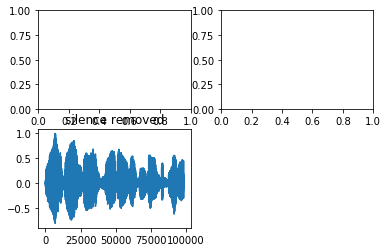

In [376]:
import wave, struct
import soundfile as sf
# let's add some metadata
class cleanAudio:
    def __init__(self,filename,label,duration,samplingRate,trim,wavform,normalized):
        self.filename = filename
        self.label = label
        self.duration = duration
        self.samplingRate = samplingRate
        self.trim = trim
        self.wavform = wavform
        self.normalized = normalized
    def showMeClean(self): #does the audio need to be clean?
        print("clean", self.clean)
    def normalize(self):
        if self.normalized == 0 :
            recording = self.wavform
            recording = recording/np.max(recording)
            self.normalized = 1
            self.wavform = recording
    def trimSilence(self):
        recording1 = []
        recording2 = []
        record = []
        if self.trim == 0:
            recording = np.asarray(self.wavform)
            index = librosa.effects.split(recording[:,0], top_db = 22, frame_length=1024, hop_length=512)
            for i in range(len(index)):
                rec1 = recording[index[i][0]:index[i][1],0]
                recording1.extend(rec1)
        self.wavform  = np.asarray(recording1)
        

        

            
# example file
x =sf.read('file1.wav')
exampleSignal = cleanAudio(filename = 'file0.wav', label = 'speech', duration = 10, samplingRate = 44100
                           , trim = 0, wavform = x[0], normalized = 0)
plt.figure(1)
# plt.subplot(221)
# plt.plot(exampleSignal.wavform)

exampleSignal.normalize()
exampleSignal.normalized
# plt.subplot(222)
# plt.plot(exampleSignal.wavform[:,0])


plt.subplot(223)
exampleSignal.trimSilence()
plt.plot(exampleSignal.wavform)
plt.title('silence removed')

# Record and Transcribe

Speak at 10 seconds intervals
recording...
processing...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Setting up audio process


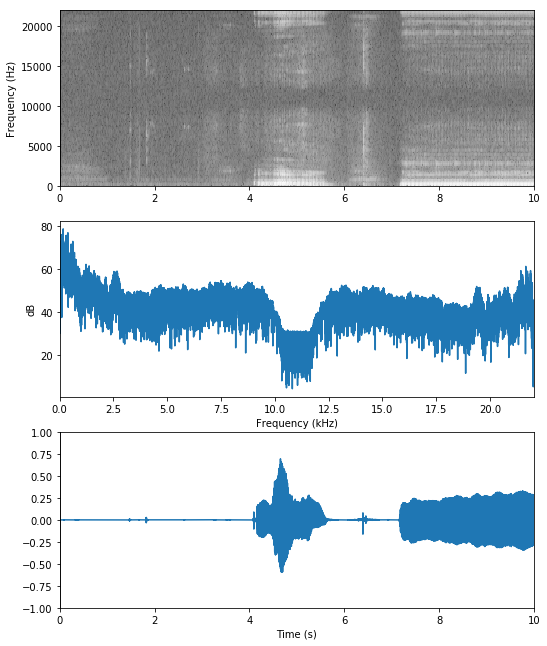

" hello 1 2 3"
Sending data to the cloud!
recording...
processing...
Setting up audio process


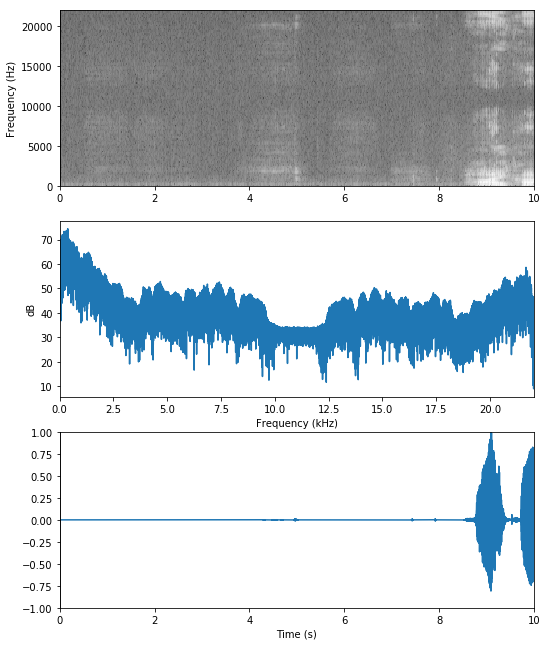

" hi hi hi laptop123 computer"
recording...
processing...
Setting up audio process


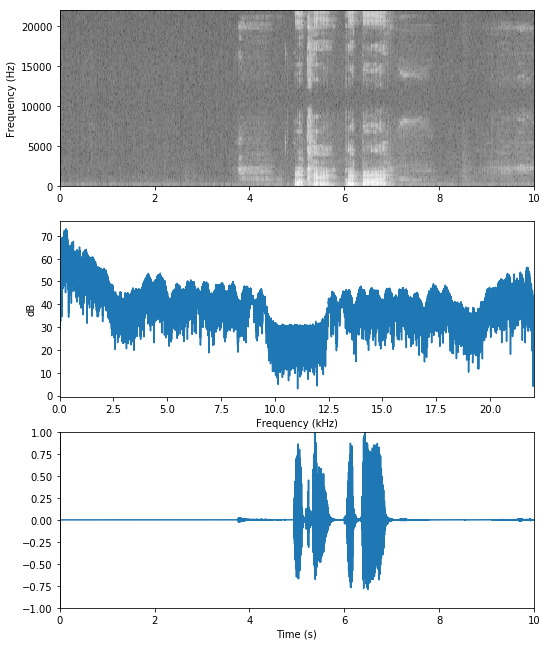

" okay goodbye okay goodbye"
okay, see you later!


In [171]:
trans_data = {'filename':['']*100, 'text':['']*100, 'cloud':['']*100} #placeholder for data

# initializing recording variables 
r = sr.Recognizer()
RECORD_SECONDS =10 # how long to listen at each time in seconds
RATE = 44100 #sampling rate
CHANNELS = 2 #number of channels

print("Speak at " + str(RECORD_SECONDS) + " seconds intervals")

for i in range(60): #600 seconds total
    FILENAME = "file" + str(i) + ".wav" #file names
    recordAudio(FILENAME,RATE, RECORD_SECONDS,CHANNELS)
    
    # openning the file, this is only for visualization
    wf = wave.open(FILENAME, 'rb')
    audioData = np.fromstring(wf.readframes(int(RECORD_SECONDS*RATE*2/CHANNELS)), dtype=int)
    plotAudio(FILENAME,RECORD_SECONDS)
    
    # audio object for recognition
    AUDIO_FILE = path.join(path.dirname(path.realpath(FILENAME)), FILENAME)
    
    with sr.AudioFile(AUDIO_FILE) as source:
        audio = r.record(source) #start recording
    try:
        data = transcribe(r.recognize_google,audio) #sending data for transcription
        print("\" "+ data + "\"")
        trans_data.get('filename')[i] = FILENAME #putting data in dataframe
        trans_data.get('text')[i] = data
        # catch errors 
    except sr.UnknownValueError:
        print("I could not understand you")  
        
    if "hello" in data or "Hello" in data: #welcome the user!
        
        print("Sending data to the cloud!")
        trans_data.get('filename')[i] = FILENAME #putting data in dataframe, simulating cloud?!
        trans_data.get('cloud')[i] = data
        
    if "goodbye" in data or "Goodbye" in data: # stop the recognition, step out of the for loop
        
        print("okay, see you later!")
        break;
    

# Result

In [172]:
df = pd.DataFrame(trans_data, columns = ['filename', 'text', 'cloud'])
df.to_csv('data'+str(datetime.date.today())+'.csv')
df

filename                         text        cloud
0   file0.wav                  hello 1 2 3  hello 1 2 3
1   file1.wav  hi hi hi laptop123 computer             
2   file2.wav    okay goodbye okay goodbye             
3                                                      
4                                                      
5                                                      
6                                                      
7                                                      
8                                                      
9                                                      
10                                                     
11                                                     
12                                                     
13                                                     
14                                                     
15                                                     
16                                                     
17                                                     
18                                                     
19                                                     
20                                                     
21                                                     
22                                                     
23                                                     
24                                                     
25                                                     
26                                                     
27                                                     
28                                                     
29                                                     
..        ...                          ...          ...
70                                                     
71                                                     
72                                                     
73                                                     
74                                                     
75                                                     
76                                                     
77                                                     
78                                                     
79                                                     
80                                                     
81                                                     
82                                                     
83                                                     
84                                                     
85                                                     
86                                                     
87                                                     
88                                                     
89                                                     
90                                                     
91                                                     
92                                                     
93                                                     
94                                                     
95                                                     
96                                                     
97                                                     
98                                                     
99                                                     

[100 rows x 3 columns]